In [1]:
import numpy as np
import pandas as pd

In [2]:
# df=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv")

In [3]:
# import csv
# import random

# def reservoir_sampling(iterable, k, header=True):
#     reservoir = []
#     for i, item in enumerate(iterable):
#         if i < k:
#             reservoir.append(item)
#         else:
#             j = random.randint(0, i)
#             if j < k:
#                 reservoir[j] = item
#     return reservoir

# # Open the input CSV file
# with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv") as f:
#     # Check if header line exists
#     header = True
#     first_line = f.readline()
#     if not first_line.startswith('step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud'):
#         header = False
#         f.seek(0)  # Rewind file pointer to beginning

#     # Sample from remaining lines
#     sampled_lines = reservoir_sampling(f, k=1100000, header=header)

# # Open the output CSV file and write the subsample to it
# with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample1300000.csv", mode='w', newline='') as f:
#     writer = csv.writer(f)
#     if header:
#         writer.writerow(first_line.strip().split(','))
#     for line in sampled_lines:
#         writer.writerow(line.strip().split(','))

In [4]:
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample.csv")

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['type'])
label
df_sample.drop("type", axis=1, inplace=True)
df_sample["type"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameDest'])
label
df_sample.drop("nameDest", axis=1, inplace=True)
df_sample["nameDest"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameOrig'])
label
df_sample.drop("nameOrig", axis=1, inplace=True)
df_sample["nameOrig"] = label

In [6]:
import pandas as pd

# assuming df is your dataframe
new_order = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type', 'nameDest', 'nameOrig', 'isFraud']

# create a new dataframe with columns in the desired order
df_sample = df_sample.drop(columns=['isFraud']).assign(isFraud=df_sample['isFraud'])

# check that the new dataframe has columns in the desired order
print(df_sample.columns.tolist())

['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type', 'nameDest', 'nameOrig', 'isFraud']


In [7]:
from sklearn.model_selection import train_test_split

X = df_sample.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998693
1    0.001307
Name: isFraud, dtype: float64
0    0.998693
1    0.001307
Name: isFraud, dtype: float64
0    0.998691
1    0.001309
Name: isFraud, dtype: float64


In [8]:
X_train.shape

(990000, 10)

In [9]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=0)

#Downsample via RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.4, random_state=0)

#Application of the resampling methods
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

In [10]:
X_resampled.shape

(692093, 10)

In [11]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [12]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [13]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [14]:
import random
import numpy as np
from scipy import stats

random.seed(0)
# Specify columns with outliers
cols_with_outliers = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Specify the number of bootstrapped samples to create per column
num_samples = 50

# Specify the right trimming proportions for each column
trim_props = {'amount': 0.01, 'oldbalanceOrg': 0.07, 'newbalanceOrig': 0.015, 'oldbalanceDest': 0.015, 'newbalanceDest': 0.01}

# Initialize empty dictionaries to store the trimmed means for each column
train_trimmed_means = {}

# Loop over the specified columns
for col_name in cols_with_outliers:
    
    # Check if the trimming proportion for this column is 0
    if trim_props[col_name] == 0:
        # If so, skip this column and move on to the next one
        continue
    
    # Initialize empty lists to store the bootstrapped samples and the trimmed means for the training set
    train_bootstrapped_samples = []
    train_trimmed_means_list = []
    
    # Loop over the number of desired samples
    for i in range(num_samples):
        # Randomly select indices from the column in the training set
        train_sample_indices = np.random.choice(X_train_resampled_final.index, size=len(X_train_resampled_final), replace=True)
        
        # Create a bootstrapped sample by indexing into the column with the selected indices for the training set
        train_sample = X_train_resampled_final.loc[train_sample_indices, col_name]
        
        # Append the bootstrapped samples to the list for the training set
        train_bootstrapped_samples.append(train_sample)
        
        # Calculate the right trimmed mean of the bootstrapped sample for the training set
        train_right_trimmed_mean = np.mean(train_sample[train_sample <= np.percentile(train_sample, 100*(1-trim_props[col_name]))])
        train_trimmed_means_list.append(train_right_trimmed_mean)
        
    # Calculate the mean of the right trimmed means for the training set and add it to the dictionary
    train_trimmed_means[col_name] = np.mean(train_trimmed_means_list)

    # Replace the outliers in the training set with the trimmed means
    X_train_resampled_final.loc[X_train_resampled_final[col_name] > np.percentile(X_train_resampled_final[col_name], 100*(1-trim_props[col_name])), col_name] = train_trimmed_means[col_name]
    
    # Replace the outliers in the test set with the trimmed means obtained from the train set
    test_outliers = X_test.loc[X_test[col_name] > np.percentile(X_test[col_name], 100*(1-trim_props[col_name])), col_name]
    X_test.loc[test_outliers.index, col_name] = train_trimmed_means[col_name]
    
# Print the trimmed means for each column separately for the training set
print("Train set trimmed means: ", train_trimmed_means)

Train set trimmed means:  {'amount': 582330.3519535997, 'oldbalanceOrg': 391713.6957469651, 'newbalanceOrig': 401785.1326952566, 'oldbalanceDest': 693747.4535151282, 'newbalanceDest': 1053396.0682621032}


In [15]:
# import module
from sklearn.preprocessing import StandardScaler

# compute required values
scaler = StandardScaler()
model = scaler.fit(X_train_resampled_final)
X_train_resampled_final = model.transform(X_train_resampled_final)

model = scaler.fit(X_test)
X_test = model.transform(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


C:\Users\23059\anaconda3\envs\test2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Test MSE: 0.51957
Test MSE: 0.52481


C:\Users\23059\anaconda3\envs\test2\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


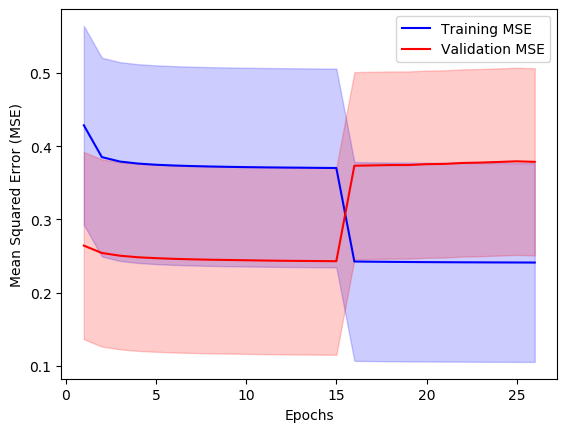

In [16]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 50
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
test_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=15, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)
    
    # Calculate the MSE for the test set
    test_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    test_mse.append(test_error)
    print(f"Test MSE: {test_error:.5f}")

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

In [17]:
# Generate reconstructed outputs for the test set
reconstructed = autoencoder.predict(X_test)

# Calculate the MSE between the input and the reconstructed output for each data point
recon_errors = np.mean(np.power(X_test - reconstructed, 2), axis=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3438/3438 [==============================] - 4s 1ms/step


In [18]:
test_mse_fold = np.mean(recon_errors)
test_mse.append(test_mse_fold)

In [19]:
# Print the final mean and standard deviation of reconstruction error across all folds
print(f"Mean Reconstruction Error: {np.mean(test_mse):.5f}")

Mean Reconstruction Error: 0.52091


In [20]:
print("Mean Train MSE:", mean_train_mse)

Mean Train MSE: [0.42843625 0.38502929 0.37897223 0.37622684 0.37461543 0.37355676
 0.37280217 0.37220877 0.37175125 0.37136418 0.371052   0.37079829
 0.3706086  0.37034583 0.3701764  0.24259314 0.24231507 0.242098
 0.24191187 0.24175277 0.2416209  0.24151202 0.24141259 0.24132715
 0.24125095 0.24117644]


In [21]:
mean_train_mse_avg = np.mean(mean_train_mse)
print("Mean Train MSE (Average):", mean_train_mse_avg)

Mean Train MSE (Average): 0.3198813538138683


In [22]:
mse = autoencoder.evaluate(X_test, X_test)
print('Mean squared error on test data:', mse)

3438/3438 [==============================] - 4s 1ms/step - loss: 0.5248
Mean squared error on test data: 0.5248116254806519
